# **Notebook for Time Series Analysis**



**Authors**: Tommaso Baroni, Luca Bestagno

**Dataset**: Electric Vehicle Temperature Dataset

## **Context**

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

## **Content**

All recordings are sampled at **2 Hz**. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". **A measurement session can be between one and six hours long**.

The motor is excited by hand-designed driving cycles denoting a reference **motor speed** and **a reference torque**.
Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

## **Goal**
Our focus will be on predicting the 'stator_winding' temperature. The interdependencies between 'stator_winding', 'stator_yoke', and 'stator_tooth' temperatures suggest that accurate predictions of one can yield significant insights into the others. Furthermore, the 'stator_winding' temperature's correlation with 'pm', representing the rotor temperature, indicates that our predictive model can also enhance our understanding of the rotor's thermal state. By targeting 'stator_winding', we aim to develop a model that offers a comprehensive view of the motor's thermal dynamics.

By predicting stator temperatures, we aim to enable preemptive maintenance actions, enhance the longevity of motors, and ensure safety in applications where temperature spikes could lead to catastrophic failures. The success of this endeavor has the potential to significantly reduce downtime and maintenance costs while optimizing performance in various industrial and vehicular applications.


# Importing Libraries and Data Loading

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

# **COLUMNS**

**u_q**

Voltage q-component measurement in dq-coordinates (in V)

**coolant**

Coolant temperature (in °C)

**stator_winding**

Stator winding temperature (in °C) measured with thermocouples

**u_d**

Voltage d-component measurement in dq-coordinates

**stator_tooth**

Stator tooth temperature (in °C) measured with thermocouples

**motor_speed**

Motor speed (in rpm)

**i_d**

Current d-component measurement in dq-coordinates

**i_q**

Current q-component measurement in dq-coordinates

**pm**

Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.

**stator_yoke**

Stator yoke temperature (in °C) measured with thermocouples

**ambient**

Temperature of the environment in which the test was performed (in °C)

**torque**

Resultant torque generated by the PMSM (in Nm)



# Exploratory Data Analysis (EDA)

In [ ]:
# Overview of the Dataset
df.info()

In [ ]:
# Statistical Analysis of the Dataset
df.describe()

In [ ]:
# Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

Let's now see the session lengths

In [ ]:
# Calculate the session lengths
session_lengths = df['profile_id'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
session_lengths.plot(kind='bar')
plt.title('Session Lengths')
plt.xlabel('Profile ID')
plt.ylabel('Number of Records')
plt.show()

Let's see how variables are correlated.

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, various insights are shown:

+ i_q and torque are directly correlated. This is due to the fact that i_q is the current variable which is directly responsable to the torque control in PMSMs.
+ stator_yoke, stator_tooth and stator_winding, all temperatures related to the stator mechanical part, all share a high correlation among them.
+ stator_yoke also shows a high correlation (0.86) with the coolant variable, which is the coolant temperature.

In addition to the significant correlations already identified, the rotor temperature (denoted as ’pm’) exhibits a high degree of correlation with the various stator temperatures. Such strong correlations imply that rotor temperature, which is crucial for monitoring and control but challenging to measure directly in commercial applications, could be inferred from stator temperatures.


In [ ]:
#visualize the correlation between the temperature stator yoke, stator tooth and stator winding
plt.figure(figsize=(20,5))
df[df['profile_id'] == 20]['stator_yoke'].plot(label = 'stator yoke')
df[df['profile_id'] == 20]['stator_tooth'].plot(label = 'stator tooth')
df[df['profile_id'] == 20]['stator_winding'].plot(label = 'stator winding')
df[df['profile_id'] == 20]['pm'].plot(label = 'rotor temperature')
plt.legend()

# Feature Engineering

Let's start by normalizing our data, excluding the "profile_id" variable.

In [10]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [11]:
df_norm = apply_z_score_normalization_except_profile_id(df)

This is for segmentation, by changing 'average_segment_length' the segmentation length is set. An 'average_segment_length' of 1 means no segmentation.

In [12]:
# Desired average segment length
average_segment_length = 2

paa_transformed_data = pd.DataFrame()


for profile_id in df_norm['profile_id'].unique():
    profile_data = df_norm[df_norm['profile_id'] == profile_id]

    # Select multiple columns correctly using a list
    columns_to_transform = ['u_q', 'coolant', 'stator_winding',	'u_d',	'stator_tooth',	'motor_speed',	'i_d',	'i_q',	'pm',	'stator_yoke',	'ambient', 'torque']
    time_series_data = profile_data[columns_to_transform]

    # Calculate the number of segments
    series_length = len(time_series_data)
    num_segments = max(1, series_length // average_segment_length)  # Ensure at least one segment

    # Initialize a DataFrame to hold the PAA-transformed series for this profile_id
    paa_transformed = pd.DataFrame(index=range(num_segments), columns=columns_to_transform)

    # Calculate the length of each segment
    segment_length = series_length // num_segments

    # Loop over the segments and compute the mean for each column
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = min(start_idx + segment_length, series_length)  # Ensure not to exceed series length
        segment_means = profile_data[start_idx:end_idx][columns_to_transform].mean()
        paa_transformed.iloc[i] = segment_means

    # Add profile_id to the transformed DataFrame
    paa_transformed['profile_id'] = profile_id

    # Add the PAA-transformed data for this profile_id to the main DataFrame
    paa_transformed_data = pd.concat([paa_transformed_data, paa_transformed], ignore_index=True)




Now let's enhance the DataFrame by adding Exponentially Weighted Average (EWA) features for each original column.

In [13]:
def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    
    exclude_columns = set(exclude_columns) | {'profile_id'}
    original_columns = [col for col in df.columns if col not in exclude_columns]

    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df

In [ ]:
exclude_columns = ['stator_winding']

spans = [600]

data_df = add_ewa_features_by_profile_id(paa_transformed_data, spans, exclude_columns)

features = data_df.columns

print(features)

# Model Building

We built different models to predict the 'stator_winding' variable:

+ A Random Forest Regressor
+ A Unidirectional LSTM
+ A resLSTM

## Random Forest Approach

We started by trying to predict the 'stator_winding' value with a Random Forest regressor.

Here we split data into training and test set, giving 80% of profile_id sessions to training.

In [15]:
unique_sessions = df['profile_id'].unique()
total_sessions_r = len(unique_sessions)

train_session_count = int(total_sessions_r * 0.8)
last_train_profile_id = unique_sessions[train_session_count - 1]
last_train_index = data_df[data_df['profile_id'] == last_train_profile_id].index[-1]

# Split the data into train and test sets
train_df = data_df.iloc[:last_train_index + 1]
test_df = data_df.iloc[last_train_index + 1:]

test_profile_mapping = test_df['profile_id']

In [16]:
# For the training set
X_train_r = train_df.drop(['stator_winding', 'profile_id'], axis=1)  # Drop 'stator_winding' and 'profile_id' from the features
y_train_r = train_df['stator_winding']  # Target variable

# For the testing set
X_test_r = test_df.drop(['stator_winding', 'profile_id'], axis=1)  # Drop 'stator_winding' and 'profile_id' from the features
y_test_r = test_df['stator_winding']  # Target variable

Random Forest Regressor Training.

In [ ]:
# training the Random Forest Regressor on the dataset
RFR_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFR_model.fit(X_train_r, y_train_r)

Predicting and computing metrics on the model.

In [ ]:
y_pred = RFR_model.predict(X_test_r)

RFR_MSE = mean_squared_error(y_test_r, y_pred)
RFR_MAE = mean_absolute_error(y_test_r, y_pred)
RFR_RMSE = mean_squared_error(y_test_r, y_pred, squared=False)
RFR_R2 = r2_score(y_test_r, y_pred)

# Output the metrics
print("MSE: {0}".format(RFR_MSE))
print("MAE: {0}".format(RFR_MAE))
print("RMSE: {0}".format(RFR_RMSE))
print("R-squared: {0}".format(RFR_R2))

Plotting all the test session predictions against real values.

In [ ]:
def plot_session_predictions(model, X_test, y_test, profile_mapping):
    unique_profiles = profile_mapping.unique()

    for profile_id in unique_profiles:

        session_indices = profile_mapping == profile_id
        X_test_session = X_test[session_indices]
        y_test_session = y_test[session_indices]

        y_pred_session = model.predict(X_test_session)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_session.values, label='Actual', color='blue')
        plt.plot(y_pred_session, label='Predicted', color='red', alpha=0.7)
        plt.title(f'Actual vs Predicted - Session {profile_id}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Stator Winding')
        plt.legend()
        plt.show()


plot_session_predictions(RFR_model, X_test_r, y_test_r, test_profile_mapping)

## Neural Network Approaches

We created two different models: a simple Unidirectional LSTM and then a resLSTM.

### Hyperparameters Definition

Here we are defining the hyperparameters shared by our models.

In [18]:
# Hyperparameters
downsample_rate = 4
n_dev = 2
n_test = 1
target = ['stator_winding']

### Batches creation and Train/Validation/Test Split

We created batches in order to feed the LSTM with proper data for training.

In [19]:
IDs = np.array(data_df['profile_id'].unique())

Here is the function used to downsample data and apply zero-padding to time series.

In [20]:
# Creates single sample array of shape (1, T, n)
def get_single_sample(df, n_feat, sample_len, downsample_rate=1):
    
    # Get new length for downsampling
    new_len = int(np.floor((max_len + downsample_rate - 1) / downsample_rate) * downsample_rate)
    
    # Convert df to numpy array of shape (1, T, n)
    arr = df.to_numpy()
    arr = np.expand_dims(arr, axis=0)
    
    # Zero-pad to sample_len at the end of the array
    _arr = np.zeros((1, new_len - np.size(arr, 1), n_feat))
    sample = np.concatenate((arr, _arr), axis=1)
    
    # Get sample_weights (zero-padded elements should have zero weight)
    weights = np.concatenate((np.ones(arr.shape), np.zeros(_arr.shape)), axis=1)
    weights = weights[:,:,0]
    
    # Perform Downsampling
    dwn_sample = []
    dwn_weights = []
    for d in np.arange(1,downsample_rate+1):
        dwn_sample.append(sample[:,(-1+d)::downsample_rate,:])
        dwn_weights.append(weights[:,(-1+d)::downsample_rate])
    
    sample = np.concatenate(dwn_sample, axis=0)
    weights = np.concatenate(dwn_weights, axis=0)
        
    return sample, weights


In [ ]:
features = data_df.columns

features = [elem for elem in features if elem != 'stator_winding']
features = [elem for elem in features if elem != 'profile_id']
feature_len = len(features)

print(features)

print(len(features))

In [ ]:
# Prepare Data for use with LSTMs: Data needs to be in shape (m, T, n)

# get maximum length, select features and target
max_len = data_df.groupby(['profile_id']).size().max()
print(max_len)

# Prepare index for faster iteration
iter_df = data_df.copy() # copy increases memory use, but avoids errors when executed twice. Better solution?
iter_df['idx'] = data_df.index
iter_df.set_index(['profile_id', 'idx'], inplace = True)

# create (m, T, n) array for X_values, sample_weights and Y_values
batch_samples_X = []
batch_weights_X = []
batch_samples_Y = []

for pid in IDs:
    # select profile
    df = iter_df.loc[pid]
    # get X samples and weights
    sample, weights = get_single_sample(df[features], 22, max_len, downsample_rate)
    batch_samples_X.append(sample)
    batch_weights_X.append(weights)    
    # get Y samples
    sample, _ = get_single_sample(df[target], 1, max_len, downsample_rate)
    batch_samples_Y.append(sample)
    
X_vals = np.concatenate(batch_samples_X, axis=0)
X_weights = np.concatenate(batch_weights_X, axis=0)
Y_vals = np.concatenate(batch_samples_Y, axis=0)

print('Shape of batches')
print('X_vals:    ', X_vals.shape)
print('X_weights: ', X_weights.shape)
print('Y_vals:    ', Y_vals.shape)

In [ ]:
# Create train-dev-test-split for LSTMs
# (when cycles are downsampled, all downsampled parts should belong to the same set)

X_train = X_vals[:-(n_dev+n_test)*downsample_rate,:,:]
X_train_weights = X_weights[:-(n_dev+n_test)*downsample_rate,:]
Y_train = Y_vals[:-(n_dev+n_test)*downsample_rate,:,:]

X_dev = X_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]
X_dev_weights = X_weights[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:]
Y_dev = Y_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]

X_test = X_vals[-((n_test)*downsample_rate):,:,:]
X_test_weights = X_weights[-((n_test)*downsample_rate):,:]
Y_test = Y_vals[-((n_test)*downsample_rate):,:,:]

print('Shape of train-test-split')
print('train (X, weights, Y): ', X_train.shape, X_train_weights.shape, Y_train.shape)
print('dev (X, weights, Y):   ', X_dev.shape, X_dev_weights.shape, Y_dev.shape)
print('test (X, weights, Y):  ', X_test.shape, X_test_weights.shape, Y_test.shape)


### NNs Hyperparameters and Useful functions

Here we define some model hyperparameters shared by both of them.

In [24]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_dev = X_dev.astype('float32')
Y_dev = Y_dev.astype('float32')
X_train_weights = X_train_weights.astype('float32')
X_dev_weights = X_dev_weights.astype('float32')

In [25]:
n_epochs = 15
lr = 0.01
lr_decay = 1e-2
dropout_rate = 0.1
n_units = 32
n_dense_in = 16
n_dense_mid = 8
n_dense_out = 1

In [26]:
def plot_learning_curves(history, descr=' '):
    # get results
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss)) 
    
    # Plotting the loss
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, loss, 'r', label='Train')
    plt.plot(epochs, val_loss, 'b', label='Validation')
    plt.title('Loss - Train vs. Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.suptitle(descr, fontsize="x-large", fontweight='bold')
    
    return

### Unidirectional LSTM
First, let's start with a simple LSTM with a total of 7313 parameters.

In [ ]:
lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(n_units, return_sequences=True, input_shape=[None, feature_len]),
  tf.keras.layers.Dense(n_dense_mid, activation="relu"),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(n_dense_out),
])

lstm.summary()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('Training...')

history = lstm.fit(x=X_train, y=Y_train, 
                          validation_data=(X_dev, Y_dev, X_dev_weights), 
                          sample_weight=X_train_weights, 
                          epochs=n_epochs,
                          verbose=1)

print('Training Completed')

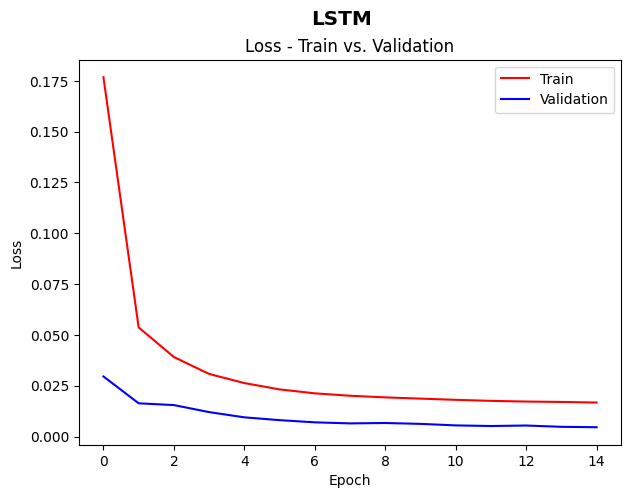

In [28]:
plot_learning_curves(history, descr = 'LSTM')

## Model Evaluation



#### Shared utils for evaluation

In [29]:
# This function makes a prediction on a given X of shape (1,Tx,1).
# The first skip_values are truncated, because initial temperature states may have large error.
# Also, only "not-zero-padded" part of the sequence is taken into account (-> sample_weight = 1).
def eval_model(model, X, Y, weights, skip_values=10, scaler=None):
    # prepare data for prediction
    end_sequence = np.where(weights==0)[1][0] # get "real" (= not-zero-padded) end of sequence
    X_pred = X[:,:end_sequence,:]
    Y_truth = Y[0,:end_sequence,0]

    # predict (and rescale if necessary)
    Y_pred = model.predict(X_pred)
    if scaler:
        Y_pred = scaler.inverse_transform(Y_pred)     
    Y_pred = Y_pred[0,:,0]
    
    # skip the first few values (large errors due to initialization phase)
    Y_pred = Y_pred[skip_values:]
    Y_truth = Y_truth[skip_values:]
        
    # calculate errors
    abs_error = np.abs(Y_pred-Y_truth)
    mse_error = np.mean(abs_error**2)    
    
    return Y_pred, Y_truth, abs_error, mse_error

# This function outputs a plot showing the prediction vs. ground truth and the corresponding error.
def plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr=' '):

    fig, axes = plt.subplots(1, 2, sharex = True, figsize=(15, 5))

    # Temperature values
    axes[0].plot(Y_truth, 'r')
    axes[0].plot(Y_pred, 'b')
    axes[0].set_title('Prediction vs. ground truth')
    axes[0].legend(['Truth', 'Prediction'])
    axes[0].set_xlabel('sample')
    axes[0].set_ylabel('Temperature')
    
    # Error
    axes[1].plot(abs_error, 'r')
    axes[1].set_title('Error (total MSE: {:.5f})'.format(mse_error))
    axes[1].set_xlabel('sample')
    axes[1].set_ylabel('Error')
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')

    return

### Unidirectional LSTM

In [ ]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='LSTM - TRAIN SET EXAMPLE')

In [ ]:
# Pick a random load cycle from the testing set for evaluation
pid_test = np.random.choice(len(X_test))  # Replace with a specific ID if needed
X_pred_test = X_test[pid_test:pid_test+1,:,:]
Y_truth_test = Y_test[pid_test:pid_test+1,:,:]
weights_test = X_test_weights[pid_test:pid_test+1,:]
X_pred_test = X_pred_test.astype('float32')
Y_truth_test = Y_truth_test.astype('float32')
weights_test = weights_test.astype('float32')

# Evaluate the model
Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test = eval_model(lstm, X_pred_test, Y_truth_test, weights_test)

# Plot the prediction vs. ground truth for the testing set
plot_prediction(Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test, descr='simple_LSTM - TEST SET EXAMPLE')

# Print out the MSE for this particular testing sample
print(f'Test MSE for profile ID {pid_test}: {mse_error_test:.5f}')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_test = X_test.astype('float32')
# Predict on the entire testing set
Y_pred_test_all = lstm.predict(X_test)
Y_truth_test_all = Y_test.squeeze()

# Reshape predictions and true values for metric calculations
Y_pred_test_all_flat = Y_pred_test_all.ravel()
Y_truth_test_all_flat = Y_truth_test_all.ravel()

# Calculate MSE
mse_test = mean_squared_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

# Calculate MAE
mae_test = mean_absolute_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate R-squared
r2_test = r2_score(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Print the metrics
print(f'Test MSE: {mse_test:.5f}')
print(f'Test RMSE: {rmse_test:.5f}')
print(f'Test MAE: {mae_test:.5f}')
print(f'Test R-squared: {r2_test:.5f}')


## ResLSTM
The ResLSTM adds residual connections to the architecture using keras functional API. The Dense layers and number of nodes of the LSTMs will be the same as the Unidirectional LSTM model.

In [ ]:
# Define the learning rate schedule
initial_learning_rate = lr  # Set your initial learning rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,  # Adjust as per your requirements
    decay_rate=0.96,     # Adjust the decay rate as needed
    staircase=True)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Build your model as before
inputs = tf.keras.layers.Input(shape=[None, feature_len])

# LSTM layer output
out_1 = tf.keras.layers.LSTM(n_units, return_sequences=True)(inputs)
out_2 = tf.keras.layers.LSTM(n_units, return_sequences=True)(out_1)
add_1 = tf.keras.layers.Add()([out_1, out_2])

# Pass LSTM output through dense layers
x = tf.keras.layers.Dense(n_dense_in, activation="relu")(add_1)
x = tf.keras.layers.Dropout(dropout_rate)(x)
y = tf.keras.layers.Dense(n_dense_out)(x)

# Create the model with inputs and the new residual_output
res_lstm = tf.keras.models.Model(inputs=[inputs], outputs=y)
res_lstm.summary()


In [ ]:
res_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Train the model
history = res_lstm.fit(
    x=X_train, 
    y=Y_train, 
    validation_data=(X_dev, Y_dev, X_dev_weights), 
    sample_weight=X_train_weights, 
    epochs=n_epochs,
    verbose=1)

print('Training Completed')

In [ ]:
plot_learning_curves(history, descr='res_LSTM')

In [ ]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(res_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='res_LSTM - TRAIN SET EXAMPLE')

In [ ]:
# Pick a random load cycle from the testing set for evaluation
pid_test = np.random.choice(len(X_test))  # Replace with a specific ID if needed
X_pred_test = X_test[pid_test:pid_test+1,:,:]
Y_truth_test = Y_test[pid_test:pid_test+1,:,:]
weights_test = X_test_weights[pid_test:pid_test+1,:]

# Evaluate the model
Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test = eval_model(res_lstm, X_pred_test, Y_truth_test, weights_test)

# Plot the prediction vs. ground truth for the testing set
plot_prediction(Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test, descr='res_LSTM - TEST SET EXAMPLE')

# Print out the MSE for this particular testing sample
print(f'Test MSE for profile ID {pid_test}: {mse_error_test:.5f}')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Predict on the entire testing set
Y_pred_test_all = res_lstm.predict(X_test)
Y_truth_test_all = Y_test.squeeze()

# Reshape predictions and true values for metric calculations
Y_pred_test_all_flat = Y_pred_test_all.ravel()
Y_truth_test_all_flat = Y_truth_test_all.ravel()

# Calculate MSE
mse_test = mean_squared_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

# Calculate MAE
mae_test = mean_absolute_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate R-squared
r2_test = r2_score(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Print the metrics
print(f'Test MSE: {mse_test:.5f}')
print(f'Test RMSE: {rmse_test:.5f}')
print(f'Test MAE: {mae_test:.5f}')
print(f'Test R-squared: {r2_test:.5f}')